In [52]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pretty_midi import PrettyMIDI, Note, Instrument
from tqdm import tqdm

from deep_pianist_identification.extractors import validate_midi
from deep_pianist_identification import utils, plotting

In [35]:
MINIMUM_FRAMES = 10

PCE_WINDOW = 15
PCE_HOP = 1

NPS_WINDOW = 1
NPS_HOP = 1

In [8]:
# Load in all splits
all_splits = []
for split in ["train", "validation", "test"]:
    split_df = pd.read_csv(os.path.join(utils.get_project_root(), f"references/data_splits/20class_80min/{split}_split.csv"), index_col=0)
    split_df["split"] = split
    all_splits.append(split_df)
df = pd.concat(all_splits, axis=0)

In [12]:
# Assign database source column
df["dataset"] = df["track"].apply(lambda x: "pijama" if "pijama/" in x else "jtd")

dataset
jtd       1001
pijama     628
Name: count, dtype: int64


In [22]:
# Load up MIDI files
all_midis = {"jtd": [], "pijama": []}
midi_root = os.path.join(utils.get_project_root(), "data/raw")
for idx, track in tqdm(df.iterrows(), total=len(df)):
    midi = track["track"]
    full_path = os.path.join(midi_root, midi, "piano_midi.mid")
    loaded = validate_midi(PrettyMIDI(full_path))
    all_midis[track["dataset"]].append(loaded)

100%|█████████████████████████████████████████████████████████████████████████████████| 1629/1629 [00:52<00:00, 31.13it/s]


In [33]:
# Preprocess MIDI files
clean_midi = {"jtd": [], "pijama": []}
for ds in all_midis.keys():
    for mid in tqdm(all_midis[ds], desc=f"Processing {ds}"):
        notes = sorted(mid.instruments[0].notes, key=lambda x: x.start)

        # Remove notes not on piano keyboard
        notes = [n for n in notes if n.pitch >= utils.MIDI_OFFSET and n.pitch <= utils.MIDI_OFFSET + utils.PIANO_KEYS]
        
        # Remove notes shorter than MIN_FRAMES
        notes = [n for n in notes if n.end - n.start >= MINIMUM_FRAMES * (1 / utils.FPS)]

        # Remove notes exceeding velocity
        notes = [n for n in notes if 0 <= n.velocity <= utils.MAX_VELOCITY]
        
        # Align start to 0 seconds
        begin = min(notes, key=lambda x: x.start).start
        notes = [Note(start=n.start-begin, end=n.end-begin, pitch=n.pitch, velocity=n.velocity) for n in notes]

        # Append note list
        clean_midi[ds].append(notes)

Processing pijama: 100%|███████████████████████████████████████████████████████████████| 628/628 [00:01<00:00, 359.98it/s]


In [34]:
def sliding_pc_entropy(notes_: list) -> float:
    """
    Calculates sliding pitch-class entropy in same manner as PiJAMA paper.
    
    Assume that `notes_` are the notes contained in a 15 second sliding window
    """
    counter = np.zeros(12)
    for note in notes_:
        counter[note.pitch % 12] += 1
    denominator = counter.sum()
    if denominator < 1:
        entropy = np.nan
    else:
        prob = counter / denominator
        with np.errstate(divide="ignore", invalid="ignore"):
            # Use natural log (not base 2) for compatibility with PiJAMA paper
            entropy = -np.nansum(prob * np.log(prob))
    return entropy

In [206]:
res = []

for ds in clean_midi.keys():
    for mid in tqdm(clean_midi[ds], desc=f"Processing {ds}"):
        # Get ending point of the MIDI file
        #  We've already aligned to start at 0
        midi_end = round(max(mid, key=lambda x: x.end).end) + 1
        
        # Extract notes-per-second
        nps_list = []
        for nps_start in range(0, midi_end, NPS_HOP):
            nps_end = nps_start + NPS_WINDOW
            notes_in = [n for n in notes if nps_start < n.start < nps_end]
            nps_list.append(len(notes_in))
        nps = np.mean(nps_list)
            
        # Extract sliding PCE
        pce_list = []
        for pce_start in range(0, midi_end, PCE_HOP):
            pce_end = pce_start + PCE_WINDOW
            notes_in = [n for n in notes if pce_start < n.start < pce_end]
            pce_list.append(sliding_pc_entropy(notes_in))
        pce = np.mean(pce_list)

        # Append all results
        data = dict(dataset=ds, pce=pce, nps=nps)
        res.append(data)
        

Processing pijama: 100%|████████████████████████████████████████████████████████████████| 628/628 [00:52<00:00, 11.91it/s]


In [58]:
res_df = pd.DataFrame(res)
# Remove extreme outliers
res_df = res_df[res_df["pce"] < 2.3]

/tmp/ipykernel_4018313/1054117714.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(yticklabels=["JTD", "PiJAMA"], ylabel="Dataset", xlabel="", title=xlab, yticks=[0.4, 1.4], ylim=[1.48, -0.28])


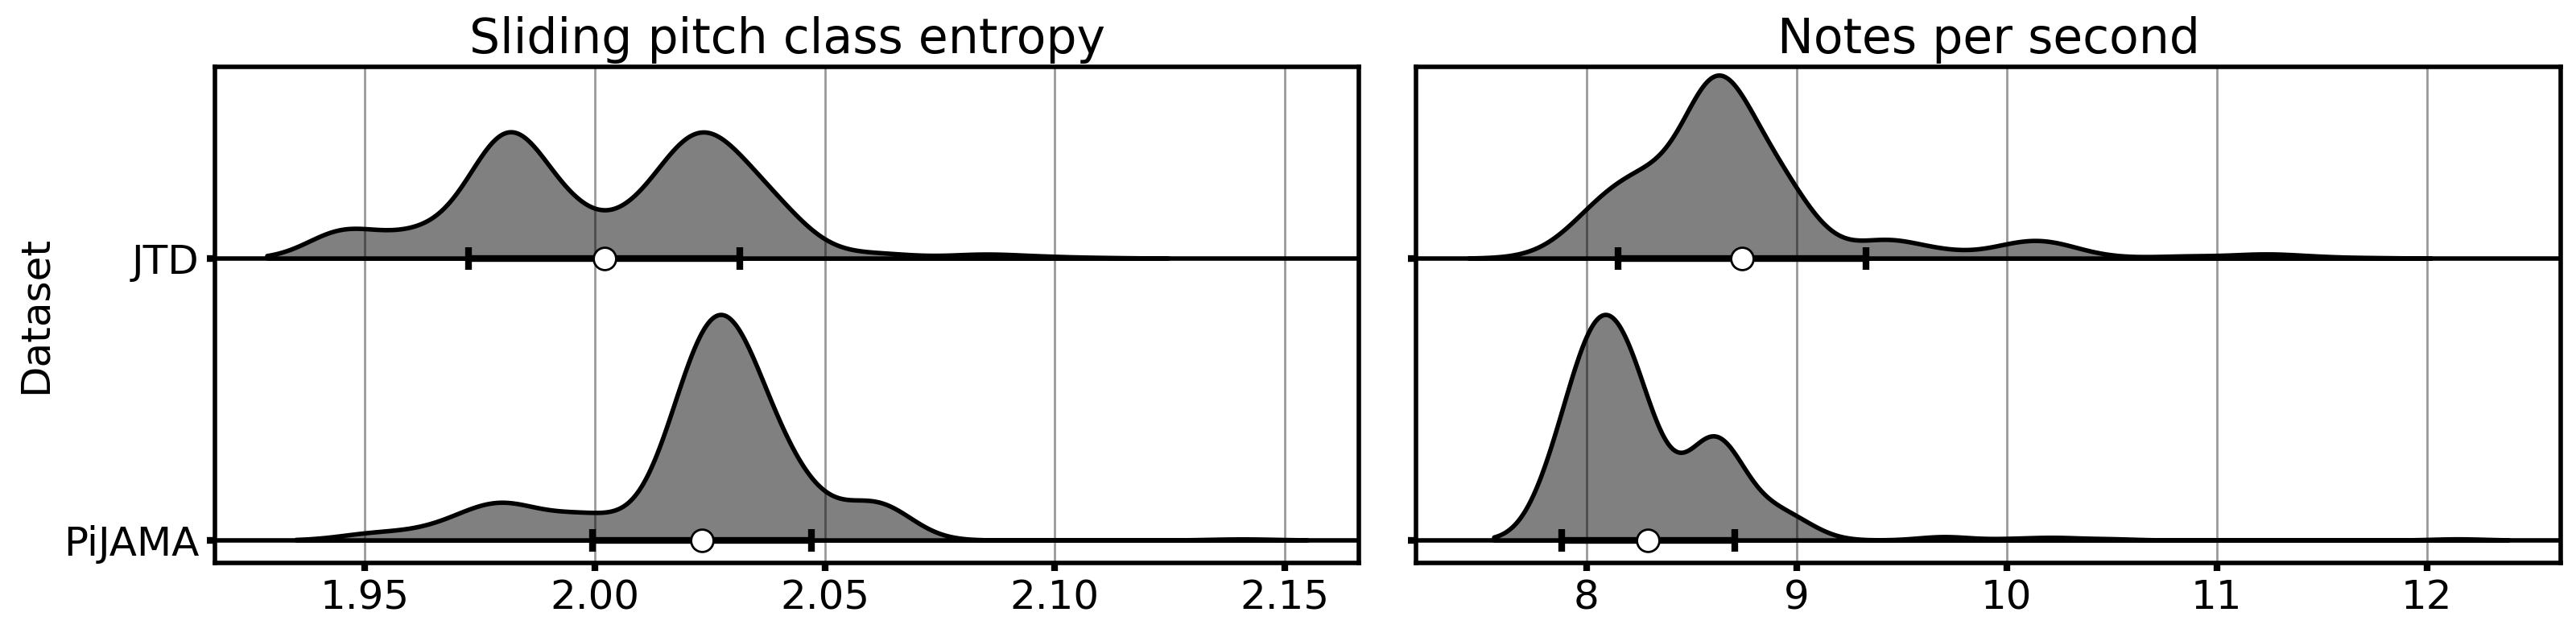

In [203]:
class KDEPlotDatasetComparison(plotting.BasePlot):
    KDE_KWS = dict(
        linecolor=plotting.BLACK, 
        facecolor="grey",
        legend=False, 
        inner=None, 
        bw_method='scott', 
        hue=True,
        hue_order=[True, False], 
        split=True,
        gridsize=plotting.N_BOOT
    )
    SCATTER_KWS = dict(
        facecolor=plotting.WHITE, lw=plotting.LINEWIDTH / 2,
        edgecolor=plotting.BLACK, s=100, zorder=15
    )
    EBAR_KWS = dict(
        ls='none', color=plotting.BLACK, linewidth=plotting.LINEWIDTH * 1.5, capsize=5,
        capthick=plotting.LINEWIDTH * 1.5, ecolor=plotting.BLACK, zorder=10
    )
    HLINE_KWS = dict(
        color=plotting.BLACK,
        linewidth=plotting.LINEWIDTH, linestyle=plotting.LINESTYLE, zorder=0
    )
    
    def __init__(self, df, **kwargs):
        super().__init__(**kwargs)
        self.fig, self.ax = plt.subplots(nrows=1, ncols=2, figsize=(plotting.WIDTH, plotting.WIDTH // 4), sharex="col", sharey=True)
        self.df = df


    def _create_plot(self):
        for ax_, var in zip(self.ax.flatten(), ["pce", "nps"]):
            a = sns.violinplot(data=self.df, x=var, y="dataset", ax=ax_, **self.KDE_KWS)
            for patch in a.collections:
                patch.set_edgecolor(plotting.BLACK)
                patch.set_linewidth(plotting.LINEWIDTH)
            for line in a.lines:
                line.set_linestyle(plotting.LINESTYLE)
                line.set_color(plotting.BLACK)
                line.set_alpha(0.8)
            # Errorbars
            means = self.df.groupby("dataset")[var].mean()
            a.scatter(x=means, y=[0.4, 1.4], **self.SCATTER_KWS)
            stds = self.df.groupby("dataset")[var].std()
            a.errorbar(x=means, y=[0.4, 1.4], xerr=stds, **self.EBAR_KWS)

            # Lines
            a.axhline(0.4, 0, 1, **self.HLINE_KWS)
            a.axhline(1.4, 0, 1, **self.HLINE_KWS)

    def _format_ax(self):
        for ax, xlab in zip(self.ax.flatten(), ["Sliding pitch class entropy", "Notes per second"]):
            ax.set(yticklabels=["JTD", "PiJAMA"], ylabel="Dataset", xlabel="", title=xlab, yticks=[0.4, 1.4], ylim=[1.48, -0.28])
            plt.setp(ax.spines.values(), linewidth=plotting.LINEWIDTH, color=plotting.BLACK)
            ax.tick_params(axis='both', width=plotting.TICKWIDTH, color=plotting.BLACK)
            ax.grid(axis='x', which='major', **plotting.GRID_KWS)

    def _format_fig(self):
        super()._format_fig()
        self.fig.subplots_adjust(wspace=0.05)


bg = KDEPlotDatasetComparison(res_df)
bg.create_plot()
plt.show()